# ЗАДАЧА

Есть приложение, частью которого является лента публикаций, которые делают пользователи. Для ленты был предложен новый алгоритм рекомендаций. Предполагается, что новый алгоритм должен увеличить конверсию просмотров в лайки - то есть новый алгоритм лучше подбирает посты, которые совпадают с интересами пользователя.

Тест проводился с 2022-04-24 по 2022-04-30. Первая группа выступала контрольной, вторая - тестовой.

Нужно проанализировать, как новый алгоритм повлиял на конверсию и проверить результаты статистическими тестами.

# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
import statsmodels.stats.api as sms
import statsmodels

from collections import namedtuple
ExperimentComparisonResults = namedtuple('ExperimentComparisonResults', 
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound', 'plot'])
ExperimentComparisonResults_2 = namedtuple('ExperimentComparisonResults', 
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound'])
from tqdm.notebook import tqdm as tqdm_notebook

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

Создадим подключение к базе данных и напишем функцию для удобства оформления запросов.

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
}

In [5]:
def select(sql):
    
    table = pandahouse.read_clickhouse(sql, connection=connection)
    return table

# Анализ данных

Получим из базы данных информацию за период эксперимента для контрольной (1) и тестовой (2) групп.

In [6]:
sql = '''

SELECT  user_id,
        toDate(time) as date,
        gender,
        age,
        os,
        source,
        country,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 1 AND 
                        (toDate(time) BETWEEN '2022-04-24' AND '2022-04-30')
GROUP BY user_id, 
         date,
         gender,
         age,
         os,
         source,
         country
ORDER BY date

'''

exp_1 = select(sql)
exp_1.head()

,user_id,date,gender,age,os,source,country,likes,views,conv
0,23535,2022-04-24,0,28,Android,ads,Russia,7,29,0.241379
1,118620,2022-04-24,1,19,iOS,organic,Russia,16,56,0.285714
2,121016,2022-04-24,1,32,Android,organic,Russia,13,50,0.260000
3,131477,2022-04-24,0,15,Android,organic,Russia,7,44,0.159091
4,130483,2022-04-24,0,22,Android,organic,Russia,6,24,0.250000


In [7]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        gender,
        age,
        os,
        source,
        country,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
FROM {db}.feed_actions 
WHERE exp_group = 2 AND 
                        (toDate(time) BETWEEN '2022-04-24' AND '2022-04-30')
GROUP BY user_id, 
         date,
         gender,
        age,
        os,
        source,
        country

ORDER BY date
'''

exp_2 = select(sql)
exp_2.head()

,user_id,date,gender,age,os,source,country,likes,views,conv
0,111843,2022-04-24,0,21,iOS,organic,Russia,8,11,0.727273
1,110668,2022-04-24,1,19,iOS,organic,Kazakhstan,6,13,0.461538
2,125246,2022-04-24,1,34,Android,organic,Russia,13,38,0.342105
3,123891,2022-04-24,0,20,Android,organic,Russia,17,54,0.314815
4,16438,2022-04-24,1,25,Android,ads,Russia,17,44,0.386364


Проверим на пропуски и дубликаты:

In [8]:
print(f'Дубликаты в первой группе: {exp_1.duplicated().sum()}')
print(f'Дубликаты вo второй группе: {exp_2.duplicated().sum()}')
print(f'Пропуски в первой группе: {exp_1.isna().mean()}')
print(f'Пропуски вo второй группе: {exp_2.isna().mean()}')

Дубликаты в первой группе: 0
Дубликаты вo второй группе: 0
Пропуски в первой группе: user_id    0.0
date       0.0
gender     0.0
age        0.0
os         0.0
source     0.0
country    0.0
likes      0.0
views      0.0
conv       0.0
dtype: float64
Пропуски вo второй группе: user_id    0.0
date       0.0
gender     0.0
age        0.0
os         0.0
source     0.0
country    0.0
likes      0.0
views      0.0
conv       0.0
dtype: float64


**Данные выгружены корректно.**

# Проверка системы сплитования

Посмотрим на размеры групп:

In [9]:
len(exp_1), len(exp_2)

(19468, 19154)

Сколько уникальных пользователей попало в каждую из групп:

In [10]:
exp_1['user_id'].nunique(), exp_2['user_id'].nunique()

(10079, 9952)

Важно проверить группы на пересечения, чтобы проверить, корректно ли сработала система сплитования:

In [11]:
set(exp_1['user_id'].unique()).intersection(set(exp_2['user_id'].unique()))

set()

**Пересечений между группами нет, пользователи распределены корректно.**

Проверим распределение пользователей в группах по полу, возрастной группе, стране, источнику трафика, операционной системе.

In [12]:
# проверим нижнюю и верхнюю возрастную границу юзеров
exp_1['age'].min(), exp_1['age'].max()

(14, 92)

In [13]:
# добавим столбец с возрастной группой
groups = [exp_1, exp_2]

for g in groups:
    g['age_group'] = np.select(
    [
        g['age'] < 18,
        (18 <= g['age']) & (g['age'] <= 35),
        (36 <= g['age']) & (g['age'] <= 50),
        (51 <= g['age']) & (g['age'] <= 70),
        g['age'] > 70

    ],
    [
        '-18',
        '18-35',
        '36-50',
        '51-70',
        '70+'
    ]
)

Напишем функцию, которая будет собирать датафрейм с количеством пользователей для двух групп по заданному параметру

In [14]:
cols = ['gender', 'age_group', 'country', 'source', 'os', 'country']

def compare_metrics(table1, table2, col):

    t1 = exp_1.groupby(col).agg(
        count = ('user_id', 'nunique')
        ).reset_index()
    t2 = exp_2.groupby(col).agg(
        count = ('user_id', 'nunique')
        ).reset_index()
    t = t1.merge(t2, how='left', on=col)
    t = t.rename(columns = {
        'count_x' : 'control',
        'count_y' : 'test'
    })
    t['diff'] = abs(t['control'] - t['test'])
    
    t['diff %'] = round(abs(t['control'] - t['test']) / t['control'] * 100, 2)
   
    return t

Теперь сравним наши экспериментальные группы:

- `gender`

In [15]:
gender_comparison = compare_metrics(exp_1, exp_2, 'gender')
gender_comparison


,gender,control,test,diff,diff %
0,0,4535,4445,90,1.98
1,1,5544,5507,37,0.67


- `age_group`

In [16]:
age_group_comparison = compare_metrics(exp_1, exp_2, 'age_group')
age_group_comparison

,age_group,control,test,diff,diff %
0,-18,1359,1284,75,5.52
1,18-35,6717,6627,90,1.34
2,36-50,1696,1718,22,1.30
3,51-70,303,317,14,4.62
4,70+,4,6,2,50.00


- `source`

In [17]:
source_comparison = compare_metrics(exp_1, exp_2, 'source')
source_comparison

,source,control,test,diff,diff %
0,ads,4720,4694,26,0.55
1,organic,5359,5258,101,1.88


- `os`

In [18]:
os_comparison = compare_metrics(exp_1, exp_2, 'os')
os_comparison

,os,control,test,diff,diff %
0,Android,6532,6409,123,1.88
1,iOS,3547,3543,4,0.11


- `country`

In [19]:
country_comparison = compare_metrics(exp_1, exp_2, 'country')
country_comparison

,country,control,test,diff,diff %
0,Azerbaijan,90,110,20,22.22
1,Belarus,212,204,8,3.77
2,Cyprus,8,12,4,50.00
3,Estonia,18,8,10,55.56
4,Finland,98,108,10,10.20
5,Kazakhstan,201,196,5,2.49
6,Latvia,10,7,3,30.00
7,Russia,8855,8731,124,1.40
8,Switzerland,8,10,2,25.00
9,Turkey,78,82,4,5.13


В целом работу системы сплитования можно считать корректной.

Изучим, как накапливались события в группах, не было ли аномалий:

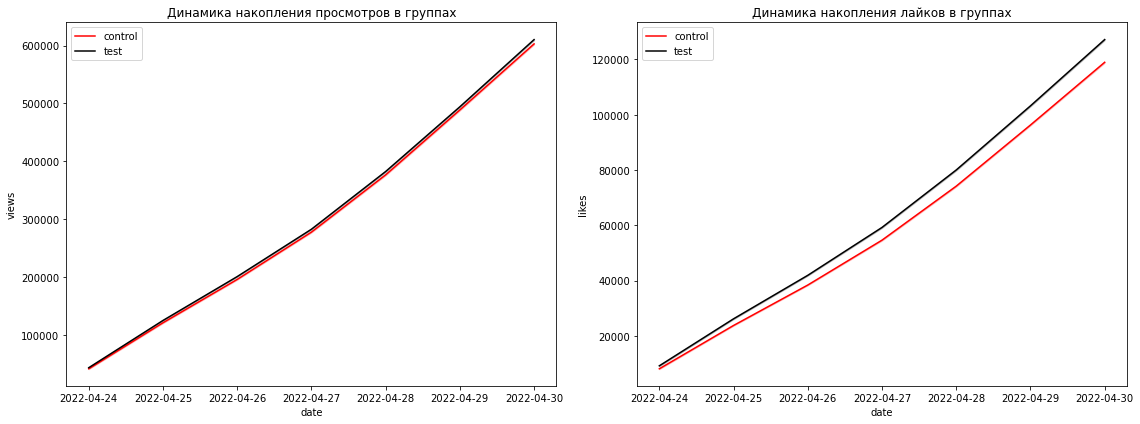

In [20]:
fig, axes = plt.subplots(figsize=(16,6))
plt.subplot(121)
ax1 = sns.lineplot(x=exp_2['date'], y=exp_2['views'].cumsum(), color='red', label='control')
ax1 = sns.lineplot(x=exp_1['date'], y=exp_1['views'].cumsum(), color='k', label='test')
plt.title('Динамика накопления просмотров в группах')
plt.subplot(122)
ax2 = sns.lineplot(x=exp_2['date'], y=exp_2['likes'].cumsum(), color='red', label='control')
ax2 = sns.lineplot(x=exp_1['date'], y=exp_1['likes'].cumsum(), color='k', label='test')
plt.title('Динамика накопления лайков в группах')
plt.tight_layout()
plt.show() 

Тестовая группа сразу же отстала от контрольной по количеству лайков, но в целом события накапливались равномерно.

Посмотрим на распределения лайков и просмотров в тестовой и контрольной группах

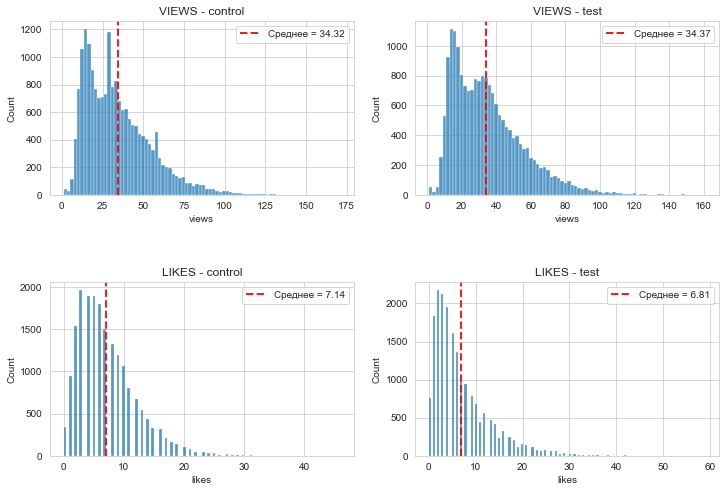

In [21]:
plt.figure(figsize = (12, 8))
plt.subplots_adjust(hspace=0.5)
plt.title('Распределение просмотров и лайков в эксперименте')
sns.set_style('whitegrid')

plt.subplot(221)
ax1 = sns.histplot(exp_1['views'])
ax1.axvline(np.mean(exp_1['views']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_1['views'])))
ax1.set_title('VIEWS - control')
plt.legend()

plt.subplot(222)
ax2 = sns.histplot(exp_2['views'])
ax2.axvline(np.mean(exp_2['views']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_2['views'])))
ax2.set_title('VIEWS - test')
plt.legend()

plt.subplot(223)
ax3 = sns.histplot(exp_1['likes'])
ax3.axvline(np.mean(exp_1['likes']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_1['likes'])))
ax3.set_title('LIKES - control')
plt.legend()

plt.subplot(224)
ax4 = sns.histplot(exp_2['likes'])
ax4.axvline(np.mean(exp_2['likes']), 
               linewidth=2, 
               color='r', 
               alpha=0.9, 
               linestyle='--', 
               label = 'Среднее = {:,.2f}'.format(np.mean(exp_2['likes'])))
ax4.set_title('LIKES - test')
plt.legend()

plt.show()

**Среднее количество просмотров на пользователя почти не изменилось, а среднее количество лайков в экспериментальной группе снизилось**. Посчитаем конверсии в группах и разницу между ними.

In [22]:
ctr1 = exp_1['likes'].sum() / exp_1['views'].sum()
ctr2 = exp_2['likes'].sum() / exp_2['views'].sum()
print(f'''
Конверсия в контрольной группе: {round(ctr1, 3)}
Конверсия в тестовой группе: {round(ctr2, 3)}

Конверсия снизилась на {round((ctr1-ctr2) / ctr1 * 100, 3)} %
''')


Конверсия в контрольной группе: 0.208
Конверсия в тестовой группе: 0.198

Конверсия снизилась на 4.791 %



Статистическую значимость этого изменения мы проверим в следующем разделе.

Построим график изменения конверсии в группах по дням:

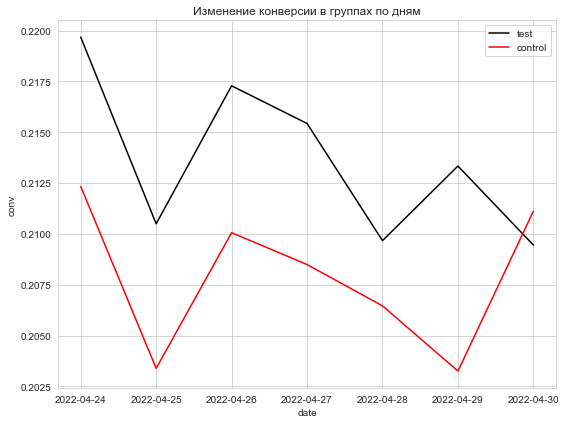

In [23]:
plt.figure(figsize=(8,6))

ax1 = sns.lineplot(data = exp_1.groupby('date', as_index=False)['conv'].mean(), x='date', y='conv', color='k', label='test', ci=None)
ax2 = sns.lineplot(data = exp_2.groupby('date', as_index=False)['conv'].mean(), x='date', y='conv', color='red', label='control', ci=None)
plt.title('Изменение конверсии в группах по дням')
plt.tight_layout()
plt.show() 

Видим, что в последний день эксперимента конверсия в тестовой группе была выше, чем в контрольной.

Посмотрим на динамику лайков и просмотров:

In [24]:
exp_1_gr = exp_1.groupby('date', as_index=False).agg(
    {
    'likes' : 'sum',
    'views' : 'sum'
    })
exp_1_gr['ctr'] = exp_1_gr['likes'] / exp_1_gr['views']
exp_1_gr

,date,likes,views,ctr
0,2022-04-24,18195,85606,0.212544
1,2022-04-25,15927,78079,0.203986
2,2022-04-26,15646,74009,0.211407
3,2022-04-27,19057,90118,0.211467
4,2022-04-28,22425,108708,0.206287
5,2022-04-29,24024,115758,0.207536
6,2022-04-30,23737,115958,0.204703


In [25]:
exp_2_gr = exp_2.groupby('date', as_index=False).agg(
    {
    'likes' : 'sum',
    'views' : 'sum'
    })
exp_2_gr['ctr'] = exp_2_gr['likes'] / exp_2_gr['views']
exp_2_gr

,date,likes,views,ctr
0,2022-04-24,16399,83033,0.197500
1,2022-04-25,14591,76019,0.191939
2,2022-04-26,14595,72760,0.200591
3,2022-04-27,18087,91417,0.197852
4,2022-04-28,21365,107951,0.197914
5,2022-04-29,22151,114369,0.193680
6,2022-04-30,23197,112761,0.205718


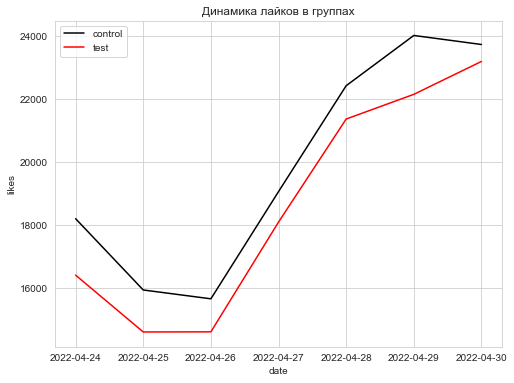

In [26]:
plt.figure(figsize=(8,6))
sns.lineplot(data=exp_1_gr, x='date', y='likes', label='control', color='k')
sns.lineplot(data=exp_2_gr, x='date', y='likes', label='test', color='red')
plt.title('Динамика лайков в группах')
plt.legend()
plt.show()

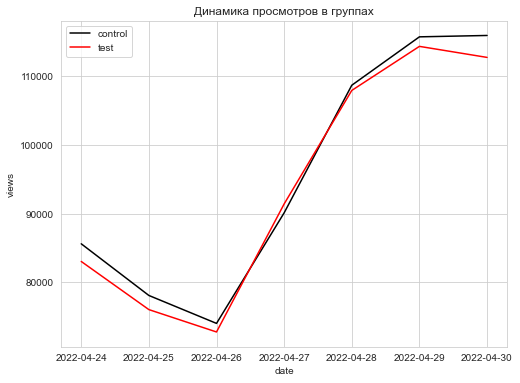

In [27]:
plt.figure(figsize=(8,6))
sns.lineplot(data=exp_1_gr, x='date', y='views', label='control', color='k')
sns.lineplot(data=exp_2_gr, x='date', y='views', label='test', color='red')
plt.title('Динамика просмотров в группах')
plt.legend()
plt.show()

В контрольной группе в последний день снизилось количество лайков, а в тестовой группе оно продолжало расти. С количеством просмотров же была обратная ситуация. Это и привело к тому, что конверсия «теста» в последний день эксперимента обогнала конверсию «контроля».

А теперь визуализируем распределение конверсий в контрольной и тестовой группах:

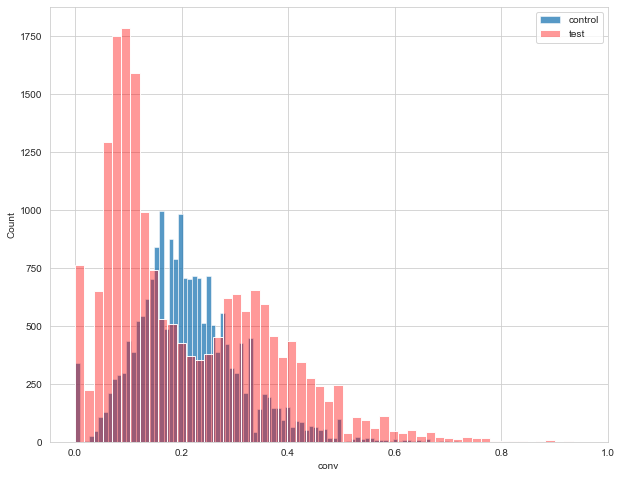

In [28]:
plt.figure(figsize=(10,8))
sns.histplot(exp_1['conv'], label='control')
sns.histplot(exp_2['conv'], color='red', alpha=0.4, label='test')
plt.legend()
plt.show()

**Между гистограммами конверсий есть заметная разница**. Нужно проанализировать новый алгоритм и посмотреть, как он повлиял на пользователей с низкой конверсией и на пользователей с высокой конверсией. Возможно, результаты такого анализа могли бы дать дополнительную полезную информацию.

Проведем анализ. Разобьем пользователей на группы по конверсии - отсечем границы групп 25-м и 75-м перцентилями.

Выгрузим данные пользователей экспериментальной группы за неделю до эксперимента.

In [29]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 2 AND 
                        (toDate(time) BETWEEN '2022-04-16' AND '2022-04-23')
GROUP BY user_id, date
ORDER BY date

'''

ctr_before = select(sql)
ctr_before.head()

,user_id,date,likes,views,conv
0,123234,2022-04-16,5,46,0.108696
1,123060,2022-04-16,2,18,0.111111
2,10276,2022-04-16,4,11,0.363636
3,108360,2022-04-16,10,73,0.136986
4,108076,2022-04-16,13,35,0.371429


Соберем список пользователей, участвовавших в эксперименте.

In [30]:
users_list = exp_2['user_id'].unique()

In [31]:
ctr_bef = ctr_before.query('user_id in @users_list')

Добавим столбец с марикровкой группы по конверсии

In [32]:
ctr_bef['perc'] = ctr_bef['conv'].apply(lambda x: 'low' if x <= np.percentile(exp_2['conv'], 25) \
     else ('high' if x >= np.percentile(exp_2['conv'], 75) else 'mid'))

ctr_bef.head()

,user_id,date,likes,views,conv,perc
1,123060,2022-04-16,2,18,0.111111,mid
5,19661,2022-04-16,7,36,0.194444,mid
6,1149,2022-04-16,9,67,0.134328,mid
7,119147,2022-04-16,0,14,0.000000,low
8,6963,2022-04-16,5,17,0.294118,mid


Переименуем столбцы для удобства

In [33]:
ctr_bef = ctr_bef.rename(columns={
    'views' : 'views_before',
    'likes' : 'likes_before'
}
)

ctr_bef = ctr_bef.groupby('perc', as_index=False).agg({
    'views_before' : 'sum',
    'likes_before' : 'sum'
})

ctr_bef['ctr_before'] = ctr_bef['likes_before'] / ctr_bef['views_before']
ctr_bef



,perc,views_before,likes_before,ctr_before
0,high,54046,20482,0.378973
1,low,20185,1191,0.059004
2,mid,453902,89831,0.197908


Проведем аналогичные манипуляции с экспериментальными данными

In [34]:
ctr_after = exp_2.query('user_id in @users_list')

ctr_aft = ctr_after.copy()
ctr_aft['perc'] = ctr_aft['conv'].apply(lambda x: 'low' if x <= np.percentile(exp_2['conv'], 25) \
     else ('high' if x >= np.percentile(exp_2['conv'], 75) else 'mid'))

ctr_aft.head()

,user_id,date,gender,age,os,source,country,likes,views,conv,age_group,perc
0,111843,2022-04-24,0,21,iOS,organic,Russia,8,11,0.727273,18-35,high
1,110668,2022-04-24,1,19,iOS,organic,Kazakhstan,6,13,0.461538,18-35,high
2,125246,2022-04-24,1,34,Android,organic,Russia,13,38,0.342105,18-35,high
3,123891,2022-04-24,0,20,Android,organic,Russia,17,54,0.314815,18-35,mid
4,16438,2022-04-24,1,25,Android,ads,Russia,17,44,0.386364,18-35,high


In [35]:
ctr_aft = ctr_aft.rename(columns={
    'views' : 'views_after',
    'likes' : 'likes_after'
}
)

ctr_aft = ctr_aft.groupby('perc', as_index=False).agg(
    {
    'views_after' : 'sum',
    'likes_after' : 'sum'
    }
    )
ctr_aft['ctr_after'] = ctr_aft['likes_after'] / ctr_aft['views_after']

ctr_aft

,perc,views_after,likes_after,ctr_after
0,high,145263,59512,0.409685
1,low,159592,9732,0.060981
2,mid,353455,61141,0.172981


In [36]:
ctr_bef

,perc,views_before,likes_before,ctr_before
0,high,54046,20482,0.378973
1,low,20185,1191,0.059004
2,mid,453902,89831,0.197908


Визуализируем расчеты и посмотрим, как поменялась конверсия по группам:

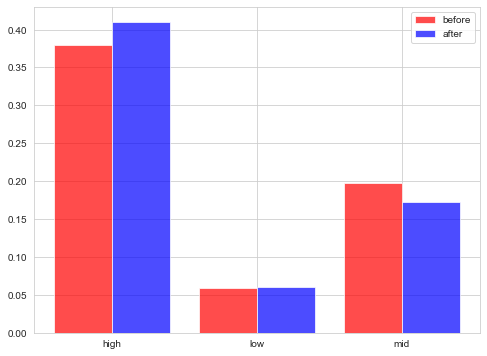

In [37]:
plt.figure(figsize=(8,6))

x_axis = np.arange(len(ctr_bef))

plt.bar(x_axis -0.2, ctr_bef['ctr_before'], width=0.4, label = 'before', color='r', alpha=0.7)
plt.bar(x_axis +0.2, ctr_aft['ctr_after'], width=0.4, label = 'after', color='b', alpha=0.7)
plt.xticks(x_axis, ctr_bef['perc'])
plt.legend()
plt.show()

**ВЫВОД**

Видим, что конверсия снизилась в средней группе и почти не изменилась в нижней. Зато прирост в конверсии показали пользователи, чья конверсия была и так высока. Возможно, это связано с тем, что ML алгоритм имеет больше возможности советовать релевантные публикации тем пользователям, которые ставят много лайков на понравившиеся посты.

# Статистические тесты

Посчитаем необходимый размер выборки для теста. В условиях задачи нам не задан размер эффекта, поэтому примем его на уровне 4% (предположим, что мы посчитали экономический эффект от роста конверсии, оправдывающий введение нового алгоритма).
Тогда нам необходимо получить наблюдений:

In [38]:
from math import ceil


required_n = statsmodels.stats.power.tt_ind_solve_power(
    0.04, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

required_n = ceil(required_n)      
required_n                      

9813

Условие выполняется, в обеих группах достаточно уникальных пользователей.

Проведем исследование и выясним, есть ли статистически значимые отличия между конверсиями в тестовой и контрольной группах. Для этого применим ряд тестов.

## T-test и тест Манна-Уитни

Посмотрим, как ведут себя критерий Манна-Уитни и Т-критерий Стьюдента в контрольной группе

In [39]:
from tqdm import tqdm_notebook

In [40]:
pvalue_t = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=1, replace=True)
  norm_2 = exp_1['conv'].sample(frac=1, replace=True)
  result = ttest_ind(norm_1, norm_2)
  pvalue_t.append(result.pvalue)
  if result.pvalue < 0.05:
    nums.append(_)
print(f'{len(nums) / len(pvalue_t) * 100}%')
    

  0%|          | 0/10000 [00:00<?, ?it/s]

5.0200000000000005%


In [41]:
pvalue_u = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=1, replace=True)
  norm_2 = exp_1['conv'].sample(frac=1, replace=True)
  result = mannwhitneyu(norm_1, norm_2)
  pvalue_u.append(result.pvalue)
  if result.pvalue < 0.05:
    nums.append(_)
print(f'{len(nums) / len(pvalue_u) * 100}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

5.06%


Посмотрим на распределение p-value

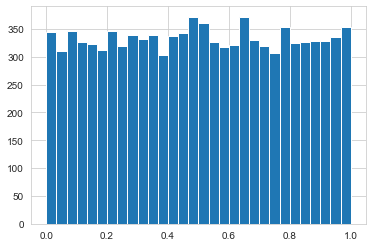

In [42]:
plt.hist(pvalue_t, bins=30)
plt.show()

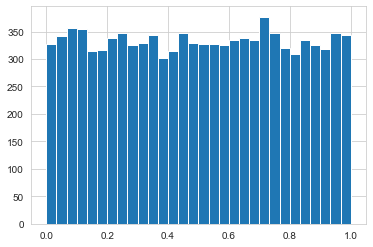

In [43]:
plt.hist(pvalue_u, bins=30)
plt.show()

Оценим мощность тестов. Создадим список значений, отличающийся на 4% от конверсии в контрольной группе и посмотрим, в каком проценте случаев тест обнаружит отличия.

In [44]:
conv_mde = exp_1['conv'] * 1.04

pvalue_t_mde = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=1, replace=True)
  norm_2 = conv_mde.sample(frac=1, replace=True)
  result = ttest_ind(norm_1, norm_2)
  pvalue_t_mde.append(result.pvalue)
  if result.pvalue > 0.05:
    nums.append(_)
print(f'Мощность t-теста: {round(100 - len(nums) / len(pvalue_t_mde) * 100, 3)}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность t-теста: 100.0%


In [45]:
pvalue_u_mde = []
nums = []

for _ in tqdm_notebook(range(10000)):
  norm_1 = exp_1['conv'].sample(frac=1, replace=True)
  norm_2 = conv_mde.sample(frac=1, replace=True)
  result = mannwhitneyu(norm_1, norm_2)
  pvalue_u_mde.append(result.pvalue)
  if result.pvalue < 0.05:
    nums.append(_)
print(f'Мощность теста Манна-Уитни: {round(len(nums) / len(pvalue_u_mde) * 100, 3)}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность теста Манна-Уитни: 100.0%


**В целом по результатам АА-теста оба критерия показывают пригодность к использованию при уровне значимости 0.05**


Сформулируем гипотезы:
- Нулевая гипотеза: конверсии в контрольной и тестовой группах равны.
- Альтернативная гипотеза: конверсии в контрольной и тестовой группах отличаются.

Сравним конверсии в контрольной и тестовой группах t-тестом:

In [46]:
alpha = 0.05
result = ttest_ind(exp_1['conv'], exp_2['conv'], equal_var=False)
p_value = result.pvalue
print(f"pvalue = {p_value}, \n")
if p_value < alpha:
      print('Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница')
else:
      print(
          'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными'
      ) 

pvalue = 1.597688696727477e-05, 

Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница


Сравним конверсии в контрольной и тестовой группах тестом Манна-Уитни:

In [47]:
alpha = 0.05
p_value = mannwhitneyu(exp_1['conv'], exp_2['conv']).pvalue
print(f"pvalue = {p_value}, \n")
if p_value < alpha:
      print('Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница')
else:
      print(
          'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группах разными'
      ) 

pvalue = 1.3469462778149872e-107, 

Отвергаем нулевую гипотезу: между конверсиями групп есть значимая разница


Посмотрим, как менялся p-value обоих критериев по дням эксперимента:

In [48]:
dates = exp_1['date'].unique()

p_t = [ttest_ind(exp_1.query(f'date <= @dates[{n}]')['conv'], exp_2.query(f'date <= @dates[{n}]')['conv'])[1] for n in range(7)]
p_m = [mannwhitneyu(exp_1.query(f'date <= @dates[{n}]')['conv'], exp_2.query(f'date <= @dates[{n}]')['conv'])[1] for n in range(7)]

p_value_dynamic = pd.DataFrame({
                                't-test' : p_t,
                                'mann_whitney' : p_m
                                },
                                index = range(1,8)
                                )
p_value_dynamic

,t-test,mann_whitney
1,0.050332,4.272023e-21
2,0.006801,6.031364e-42
3,0.000930,3.392526e-56
4,0.000132,5.005028e-78
5,0.000122,1.109714e-94
6,0.000002,2.057860e-123
7,0.000015,1.346946e-107


**Оба критерия показали статистически значимую разницу между конверсиями в группах.**

## Bootstrap

### 1 вариант

Моя собственная реализация бутстрапа.

Проверим статистическую значимость изменения конверсии при помощи бутстрапа.

In [49]:
ctr1 = []
ctr2 = []
ctr_diff = []

for _ in range(10000):
    w1 = exp_1.sample(frac=0.5, replace=True)['views'].sum()
    l1 = exp_1.sample(frac=0.5, replace=True)['likes'].sum()
    w2 = exp_2.sample(frac=0.5, replace=True)['views'].sum()
    l2 = exp_2.sample(frac=0.5, replace=True)['likes'].sum()
    
    ctr_1 = l1/w1
    ctr_2 = l2/w2
    ctr1.append(ctr_1)
    ctr2.append(ctr_2)
    ctr_diff.append(ctr_1-ctr_2)
    
ctr_diff = pd.DataFrame(ctr_diff)

pvalue = 2 * min(np.mean(ctr_diff[0] > 0), np.mean(ctr_diff[0] < 0))

print(f'p-value = {pvalue}')
if pvalue <= 0.05:
    print('Отвергаем нулевую гипотезу: между группами есть статистически значимая разница')
else: 
    print('Не можем отвергнуть нулевую гипотезу: между группами нет статистически значимой разницы')

print(f'''
Среднее значение конверсии контрольной группы: {round(np.mean(ctr1), 3)}
Среднее значение конверсии тестовой группы: {round(np.mean(ctr2), 3)}''')
  
print(f'''
Характеристики распределения конверсии контрольной группы
{pd.Series(ctr1).describe()}

Характеристики распределения конверсии тестовой группы
{pd.Series(ctr2).describe()}
''') 

p-value = 0.0004
Отвергаем нулевую гипотезу: между группами есть статистически значимая разница

Среднее значение конверсии контрольной группы: 0.208
Среднее значение конверсии тестовой группы: 0.198

Характеристики распределения конверсии контрольной группы
count    10000.000000
mean         0.208050
std          0.001881
min          0.201302
25%          0.206765
50%          0.208037
75%          0.209314
max          0.215145
dtype: float64

Характеристики распределения конверсии тестовой группы
count    10000.000000
mean         0.198113
std          0.002164
min          0.189693
25%          0.196639
50%          0.198104
75%          0.199574
max          0.206194
dtype: float64



Визуализируем результаты:

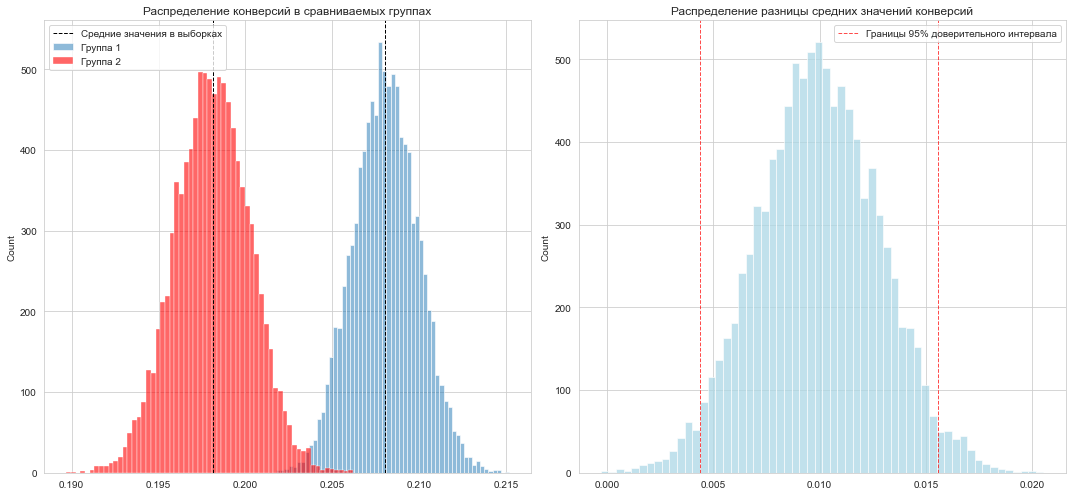

In [50]:
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
ax1 = sns.histplot(ctr1, 
                     kde=False, 
                     label=f'Группа 1',
                     alpha=0.5)
ax1.axvline(np.mean(ctr1), 
              linewidth=1, 
              color='k', 
              alpha=1, 
              linestyle='--', 
              label='Средние значения в выборках'
              )

ax1 = sns.histplot(ctr2, 
                     color = 'red', 
                     label=f'Группа 2',
                     alpha=0.6)
ax1.axvline(np.mean(ctr2), 
              linewidth=1, 
              color='k', 
              alpha=1, 
              linestyle='--', 
              )
ax1.set_title('Распределение конверсий в сравниваемых группах')
plt.legend()

plt.subplot(1,2,2)
  
sns.set_style('whitegrid')
ax2 = sns.histplot((pd.Series(ctr1) - pd.Series(ctr2)), 
                     color = 'lightblue')
ax2.axvline(ctr_diff[0].quantile(0.025), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--',
                label='Границы 95% доверительного интервала' 
                )
ax2.axvline(ctr_diff[0].quantile(0.975), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--', 
                )
ax2.set_title('Распределение разницы средних значений конверсий')
plt.legend()
plt.tight_layout()
plt.show()

**Бутстрап показывает наличие статистически значимой разницы между конверсиями.**

### 2 вариант

Аналитики из Авито написали крутую статью, которую я прочел в блоге на Хабре (https://habr.com/ru/company/avito/blog/571096/). В образовательных целях взял оттуда эту функцию с небольшими упрощениями:

In [51]:
def bootstrap(control, test):
    
    stat_sample = []
    
    batch_sz = 100
    
    # В теории boot_samples_size стоить брать не меньше размера выборки. Но на практике можно и меньше.
    boot_samples_size = len(control)
    for i in range(0, boot_samples_size, batch_sz):
        N_c = len(control)
        N_t = len(test)
        control_sample = np.random.choice(control, size=(len(control), batch_sz), replace=True)
        test_sample    = np.random.choice(test, size=(len(test), batch_sz), replace=True)

        C = np.mean(control_sample, axis=0)
        T = np.mean(test_sample, axis=0)
        assert len(T) == batch_sz
        
        # Добавляем в массив посчитанных ранее статистик batch_sz новых значений
        # X в статье – это boot_func(control_sample_mean, test_sample_mean)
        stat_sample += list(C - T)

    stat_sample = np.array(stat_sample)
    # Считаем истинный эффект
    effect = np.mean(control) - np.mean(test)
    left_bound, right_bound = np.quantile(stat_sample, [0.025, 0.975])
    
    ci_length = (right_bound - left_bound)
    # P-value - процент статистик, которые лежат левее или правее 0.
    pvalue = 2 * min(np.mean(stat_sample > 0), np.mean(stat_sample < 0))
    
    print(f'p-value = {pvalue}')
    plt.figure(figsize=(8,6))
    plot = sns.histplot(stat_sample)
    plot.axvline(np.quantile(stat_sample.tolist(), 0.025),
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--',
                label='Границы 95% доверительного интервала' 
                )
    plot.axvline(np.quantile(stat_sample.tolist(), 0.975), 
                linewidth=1, 
                color='r', 
                alpha=0.7, 
                linestyle='--', 
                )
    plt.show()
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound, plot)

p-value = 0.0


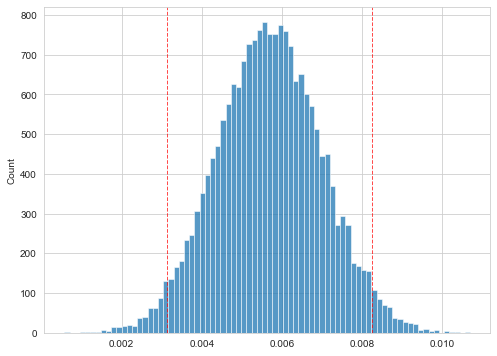

In [52]:
p_value_bootstrap_2 = bootstrap(exp_1['conv'], exp_2['conv'])

**Видим, что этот тест тоже показывает статистически значимую разницу между группами. Ноль не попадает в доверительный интервал.**

## CUPED 

Попробуем еще один способ : CUPED, это метод постанализа, понижающий дисперсию. Реализация метода взята из вышеупомянутой статьи в образовательных целях.

Для расчета предэкспериментальной метрики берем период в 1 месяц до итсследуемого эксперимента. Выгружаем данные:

In [53]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 2 AND 
                        (toDate(time) BETWEEN '2022-03-23' AND '2022-04-23')
GROUP BY user_id, date
ORDER BY date

'''

exp_tb = select(sql)
exp_tb.head()

,user_id,date,likes,views,conv
0,107546,2022-03-28,1,2,0.500000
1,524,2022-03-28,2,4,0.500000
2,107678,2022-03-28,0,7,0.000000
3,107389,2022-03-28,1,22,0.045455
4,958,2022-03-28,0,1,0.000000


In [54]:
sql = '''
SELECT  user_id,
        toDate(time) as date,
        countIf(action = 'like') as likes,
        countIf(action='view') as views,
        countIf(action = 'like') / countIf(action = 'view') as conv
        
FROM {db}.feed_actions 
WHERE exp_group = 1 AND 
                        (toDate(time) BETWEEN '2022-03-23' AND '2022-04-23')
GROUP BY user_id, date
ORDER BY date

'''

exp_cb = select(sql)
exp_cb.head()

,user_id,date,likes,views,conv
0,266,2022-03-28,1,2,0.500
1,1086,2022-03-28,1,8,0.125
2,888,2022-03-28,0,1,0.000
3,107513,2022-03-28,0,5,0.000
4,107048,2022-03-28,3,5,0.600


Создаем списки конверсий в тесте и контроле до эксперимента и во время эксперимента:

In [55]:
test_before = exp_tb['conv']
test = exp_2['conv']

control_before = exp_cb['conv']
control = exp_1['conv']


Используем функцию для вычисления параметров теста и считаем p-value.

In [56]:
def absolute_ttest(control, test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    
    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = stats.norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))

    left_bound, right_bound = difference_distribution.ppf([0.025, 0.975])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return ExperimentComparisonResults_2(pvalue, effect, ci_length, left_bound, right_bound)


In [57]:
pvalue_cuped = absolute_ttest(control, test)[0]
print(f'CUPED: p-value={pvalue_cuped}')

CUPED: p-value=1.5922144923138578e-05


**CUPED показывает наличие статистически значимых различий между контрольной и тестовой группами.**

# ВЫВОД 

- Система сплитования работает корректно - пересечений между группа не обнаружено.
- В данных нет пропусков и дубликатов.
- После введения нового алгоритма снизилось среднее количество лайков и снизилась общая конверсия: с 0.208 до 0.198.
- Для проверки статистической значимости этого изменения были применены несколько критериев: t-тест, тест Манна-Уитни, бутстрап и CUPED. Все эти методы показали, что изменение конверсии статистически значимо.
- В то же время на пользователях с высокой конверсией алгоритм показал себя хорошо: конверсия увеличилась с 34.4% до 42.5%.

**РЕКОМЕНДАЦИИ**

Изучить, почему алгоритм оказывает противоположное влияние на пользователей с высокой конверсией и на пользователей с низкой конверсией, выполнить необходимые подстройки.  Выпускать новый алгоритм в продакшн на всех пользователей не рекомендуется.